In [69]:
# Audio processing
import librosa
# import noisereduce
# Data cleaning
import os
import pandas as pd
import numpy as np
from numpy import mean, var
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Statistics
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
# Advanced options
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [70]:
FRAMESIZE = 1024
HOPLENGTH = 512
# 13 mels for fingerprint and more than 20 mels for word detection
MELS = 13
PCA_N = 2

In [71]:
# Cluster data for future work
opd_data = []
others_data = []
directory= "A:\Professional\Engineering CU\DSP_Data_New"
for dir in os.listdir(directory):
    if dir == "open the door":
        for filename in os.listdir(os.path.join(directory, dir)):
            path_opd = os.path.join(directory, dir, filename)
            opd_data.append(path_opd)
    else:
        for filename in os.listdir(os.path.join(directory, dir)):
            path_others = os.path.join(directory, dir, filename)
            others_data.append(path_others)

In [72]:
# Group all the data
data = []
data.extend(opd_data)
data.extend(others_data)

In [73]:
# Determine speakers
speaker = []
for d in data:
    if "adham" in d: # append 1 for adham
        speaker.append(1)
    if "mahmoud" in d: # append 2 for mahmoud
        speaker.append(2)
    if "ahmed" in d: # append 3 for ahmed
        speaker.append(3)
    if "maha" in d: # append 4 for maha
        speaker.append(4)
    if "others (" in d or 'input' in d:
        speaker.append(0)
len(speaker)

192

In [74]:
# Fingerprint Dataframe
fingerprints = pd.DataFrame()
fingerprints['data'] = data
fingerprints['speaker'] = speaker
fingerprints

,data,speaker
0,A:\Professional\Engineering CU\DSP_Data_New\op...,1
1,A:\Professional\Engineering CU\DSP_Data_New\op...,1
2,A:\Professional\Engineering CU\DSP_Data_New\op...,1
3,A:\Professional\Engineering CU\DSP_Data_New\op...,1
4,A:\Professional\Engineering CU\DSP_Data_New\op...,1
...,...,...
187,A:\Professional\Engineering CU\DSP_Data_New\un...,4
188,A:\Professional\Engineering CU\DSP_Data_New\un...,2
189,A:\Professional\Engineering CU\DSP_Data_New\un...,2
190,A:\Professional\Engineering CU\DSP_Data_New\un...,2


In [90]:
# Functions we will use
def transform_audio(audio, FRAMESIZE, HOPLENGTH, MELS):

    # audio_noised, sr = librosa.load(audio, duration=2)
    # audio_array = noisereduce.reduce_noise(y=audio_noised, sr=sr)
    audio_array, sr = librosa.load(audio, duration=2)

    log_mel_audio_list_mean = []
    log_mel_audio_list_var = []
    mfccs_audio_list_mean = []
    mfccs_audio_list_var = []
    cqt_audio_list_mean = []
    cqt_audio_list_var = []
    chromagram_audio_list_mean = []
    chromagram_audio_list_var = []
    tone_audio_list_mean = []
    tone_audio_list_var = []

    log_mel_audio = librosa.power_to_db(librosa.feature.melspectrogram(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS))
    mfccs_audio = librosa.feature.mfcc(y=audio_array, n_mfcc=MELS, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)

    cqt_audio = np.abs(librosa.cqt(y=audio_array, sr=sr, hop_length=HOPLENGTH))
    chromagram_audio = librosa.feature.chroma_stft(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
    tone_audio = librosa.feature.tonnetz(y=audio_array, sr=sr)

    for i in range(len(log_mel_audio)):
         log_mel_audio_list_mean.append(log_mel_audio[i].mean())
         log_mel_audio_list_var.append(log_mel_audio[i].var())

    for i in range(len(mfccs_audio)):
         mfccs_audio_list_mean.append(mfccs_audio[i].mean())
         mfccs_audio_list_var.append(mfccs_audio[i].var())

    for i in range(len(cqt_audio)):
         cqt_audio_list_mean.append(cqt_audio[i].mean())
         cqt_audio_list_var.append(cqt_audio[i].var())

    for i in range(len(chromagram_audio)):
         chromagram_audio_list_mean.append(chromagram_audio[i].mean())
         chromagram_audio_list_var.append(chromagram_audio[i].var())

    for i in range(len(tone_audio)):
         tone_audio_list_mean.append(tone_audio[i].mean())
         tone_audio_list_var.append(tone_audio[i].var())

    sc_audio = librosa.feature.spectral_centroid(y=audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
    sb_audio = librosa.feature.spectral_bandwidth(y=audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
    sr_audio = librosa.feature.spectral_rolloff(y=audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)

    ae_audio = fancy_amplitude_envelope(audio_array, FRAMESIZE, HOPLENGTH)
    rms_audio = librosa.feature.rms(audio_array, frame_length=FRAMESIZE, hop_length=HOPLENGTH)

    return np.hstack((mean(ae_audio), var(ae_audio), mean(rms_audio), var(rms_audio), mean(sc_audio), var(sc_audio), mean(sb_audio), var(sb_audio), mean(sr_audio), var(sr_audio), chromagram_audio_list_mean, chromagram_audio_list_var, tone_audio_list_mean, tone_audio_list_var, cqt_audio_list_mean, cqt_audio_list_var, mfccs_audio_list_mean, mfccs_audio_list_var, log_mel_audio_list_mean, log_mel_audio_list_var))


def fancy_amplitude_envelope(signal, framesize, hoplength):
    return np.array([max(signal[i:i+framesize]) for i in range(0, len(signal), hoplength)])

In [91]:
samples_no = len(fingerprints['data'])
features_length = len(transform_audio(fingerprints['data'].iloc[0], FRAMESIZE, HOPLENGTH, MELS))

In [92]:
features_df = pd.DataFrame()
features_df['data'] = fingerprints['data'].copy()
features_df['speaker'] = fingerprints['speaker'].copy()

for i in tqdm(range(features_length)):
    features_df[f'feature {i}'] = np.zeros(samples_no)

temp_array = []
for index, row in tqdm(features_df.iloc[:].iterrows()):
    if index < len(features_df)-1:
        array_1 = transform_audio(features_df.loc[index, ['data']][0], FRAMESIZE, HOPLENGTH, MELS)
        array_2 = transform_audio(features_df.loc[index+1, ['data']][0], FRAMESIZE, HOPLENGTH, MELS)
        combined_array = np.vstack((array_1, array_2))[0]
        temp_array.append(list(combined_array))

last_element = transform_audio(features_df.loc[len(features_df)-1, ['data']][0], FRAMESIZE, HOPLENGTH, MELS)
temp_array.append(list(last_element))


features_df.iloc[:,2:] = pd.DataFrame(temp_array).copy()
features_df

100%|██████████| 266/266 [00:00<00:00, 4663.77it/s]
192it [01:10,  2.73it/s]


,data,speaker,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,...,feature 256,feature 257,feature 258,feature 259,feature 260,feature 261,feature 262,feature 263,feature 264,feature 265
0,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.027843,0.002087,0.013634,0.000580,1886.831218,8.123023e+05,2409.485534,444727.497430,...,216.462494,176.181519,128.056839,149.693787,209.715164,148.801743,85.350876,59.285122,70.233040,65.921082
1,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.033648,0.004332,0.015390,0.000874,1956.928862,6.387933e+05,2302.179488,505915.237556,...,219.727203,170.745605,97.705536,127.613663,160.602402,135.815109,92.522125,74.727669,85.024757,104.147827
2,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.023385,0.001250,0.013316,0.000455,1822.757696,5.698119e+05,2280.717985,609810.794167,...,211.628494,204.353867,129.512207,116.327835,165.632950,190.573883,107.446518,43.292130,53.123344,51.931469
3,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.024663,0.000743,0.007930,0.000077,4601.017003,1.676146e+06,3207.467542,21074.717748,...,33.583759,28.132874,14.423258,5.036216,11.231256,8.625013,3.750520,0.598897,0.544173,0.362404
4,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.051932,0.020891,0.020185,0.001819,1813.157956,7.541774e+05,2241.470457,627994.777186,...,271.744171,223.154694,169.702164,114.854019,138.567413,167.287033,108.930367,58.179504,53.992485,42.848633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,A:\Professional\Engineering CU\DSP_Data_New\un...,4,0.015773,0.000217,0.005335,0.000030,4826.557235,8.868723e+05,3280.455819,22913.322885,...,39.137447,33.027950,7.295224,2.550004,4.270374,2.958375,1.051028,0.757277,0.480075,0.356831
188,A:\Professional\Engineering CU\DSP_Data_New\un...,2,0.047651,0.005682,0.018710,0.000937,1829.838783,7.833043e+05,2221.252490,696581.265398,...,260.199554,288.955322,152.535645,164.240067,200.829163,171.758636,178.650635,59.455601,42.259415,65.068863
189,A:\Professional\Engineering CU\DSP_Data_New\un...,2,0.051047,0.005127,0.019362,0.000863,3904.012060,3.157876e+06,2960.785129,289192.140017,...,154.288620,100.381271,21.474648,64.361992,51.115452,39.914986,15.535128,1.903714,2.089182,1.833574
190,A:\Professional\Engineering CU\DSP_Data_New\un...,2,0.039748,0.004213,0.015745,0.000659,2083.330370,1.547017e+06,2328.297810,688890.333144,...,273.135925,274.134705,121.783401,157.892990,211.429337,204.492920,150.704941,35.732243,24.178911,42.259094


In [93]:
def stat_analysis(df, n):
    #-----------------------------------------------------------------------------------------
    # Check correlation
    corr = df.corr()

    # Set up the matplotlib plot configuration
    plt.figure(figsize=(35,10))

    plt.subplot(1,2,1)

    # Generate a mask for upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Configure a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    plt.title('Correlation')
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)


    #-----------------------------------------------------------------------------------------
    # Perform PCA to make dimensionality reduction
    pca = PCA()

    # Fit the standardized data to the pca
    pca=pca.fit(df)

    # Plot the proportion of variance explained on the y-axis of the bar plot
    # Set up the matplotlib plot configuration
    plt.subplot(1,2,2)
    plt.title('PCA')
    plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
    plt.xlabel('Principal component #')
    plt.ylabel('Proportion of variance explained')
    plt.xticks(range(df.shape[1]))

    two_first_comp_var_exp = pca.explained_variance_ratio_.cumsum()[n]
    print("The cumulative variance of the first several principal components is {}".format(
    round(two_first_comp_var_exp, 5)))

In [100]:
# Select best features
X_train_feat, _, y_train_feat ,_ = train_test_split(features_df.drop(labels=['data', 'speaker'], axis=1),
    features_df.iloc[:,1],
    test_size=0.3,
    random_state=0)

mutual_info_classif(X_train_feat, y_train_feat)

sel_cols_general = SelectKBest(mutual_info_classif, k=100)
sel_cols_general.fit(X_train_feat, y_train_feat)
speaker_features_general = list(X_train_feat.columns[sel_cols_general.get_support()])
speaker_features_general

['feature 0',
 'feature 1',
 'feature 2',
 'feature 3',
 'feature 6',
 'feature 25',
 'feature 32',
 'feature 33',
 'feature 40',
 'feature 41',
 'feature 42',
 'feature 43',
 'feature 44',
 'feature 45',
 'feature 49',
 'feature 65',
 'feature 66',
 'feature 67',
 'feature 68',
 'feature 69',
 'feature 70',
 'feature 71',
 'feature 72',
 'feature 73',
 'feature 78',
 'feature 79',
 'feature 80',
 'feature 81',
 'feature 82',
 'feature 83',
 'feature 84',
 'feature 85',
 'feature 86',
 'feature 87',
 'feature 88',
 'feature 89',
 'feature 90',
 'feature 91',
 'feature 93',
 'feature 95',
 'feature 96',
 'feature 98',
 'feature 105',
 'feature 106',
 'feature 108',
 'feature 131',
 'feature 133',
 'feature 149',
 'feature 150',
 'feature 151',
 'feature 152',
 'feature 153',
 'feature 154',
 'feature 155',
 'feature 156',
 'feature 157',
 'feature 158',
 'feature 161',
 'feature 163',
 'feature 164',
 'feature 165',
 'feature 166',
 'feature 167',
 'feature 168',
 'feature 169',
 'featu

In [101]:
# to see the correlation between the target and the other features
temp = speaker_features_general.copy()
temp.append('speaker')

The cumulative variance of the first several principal components is 0.99943


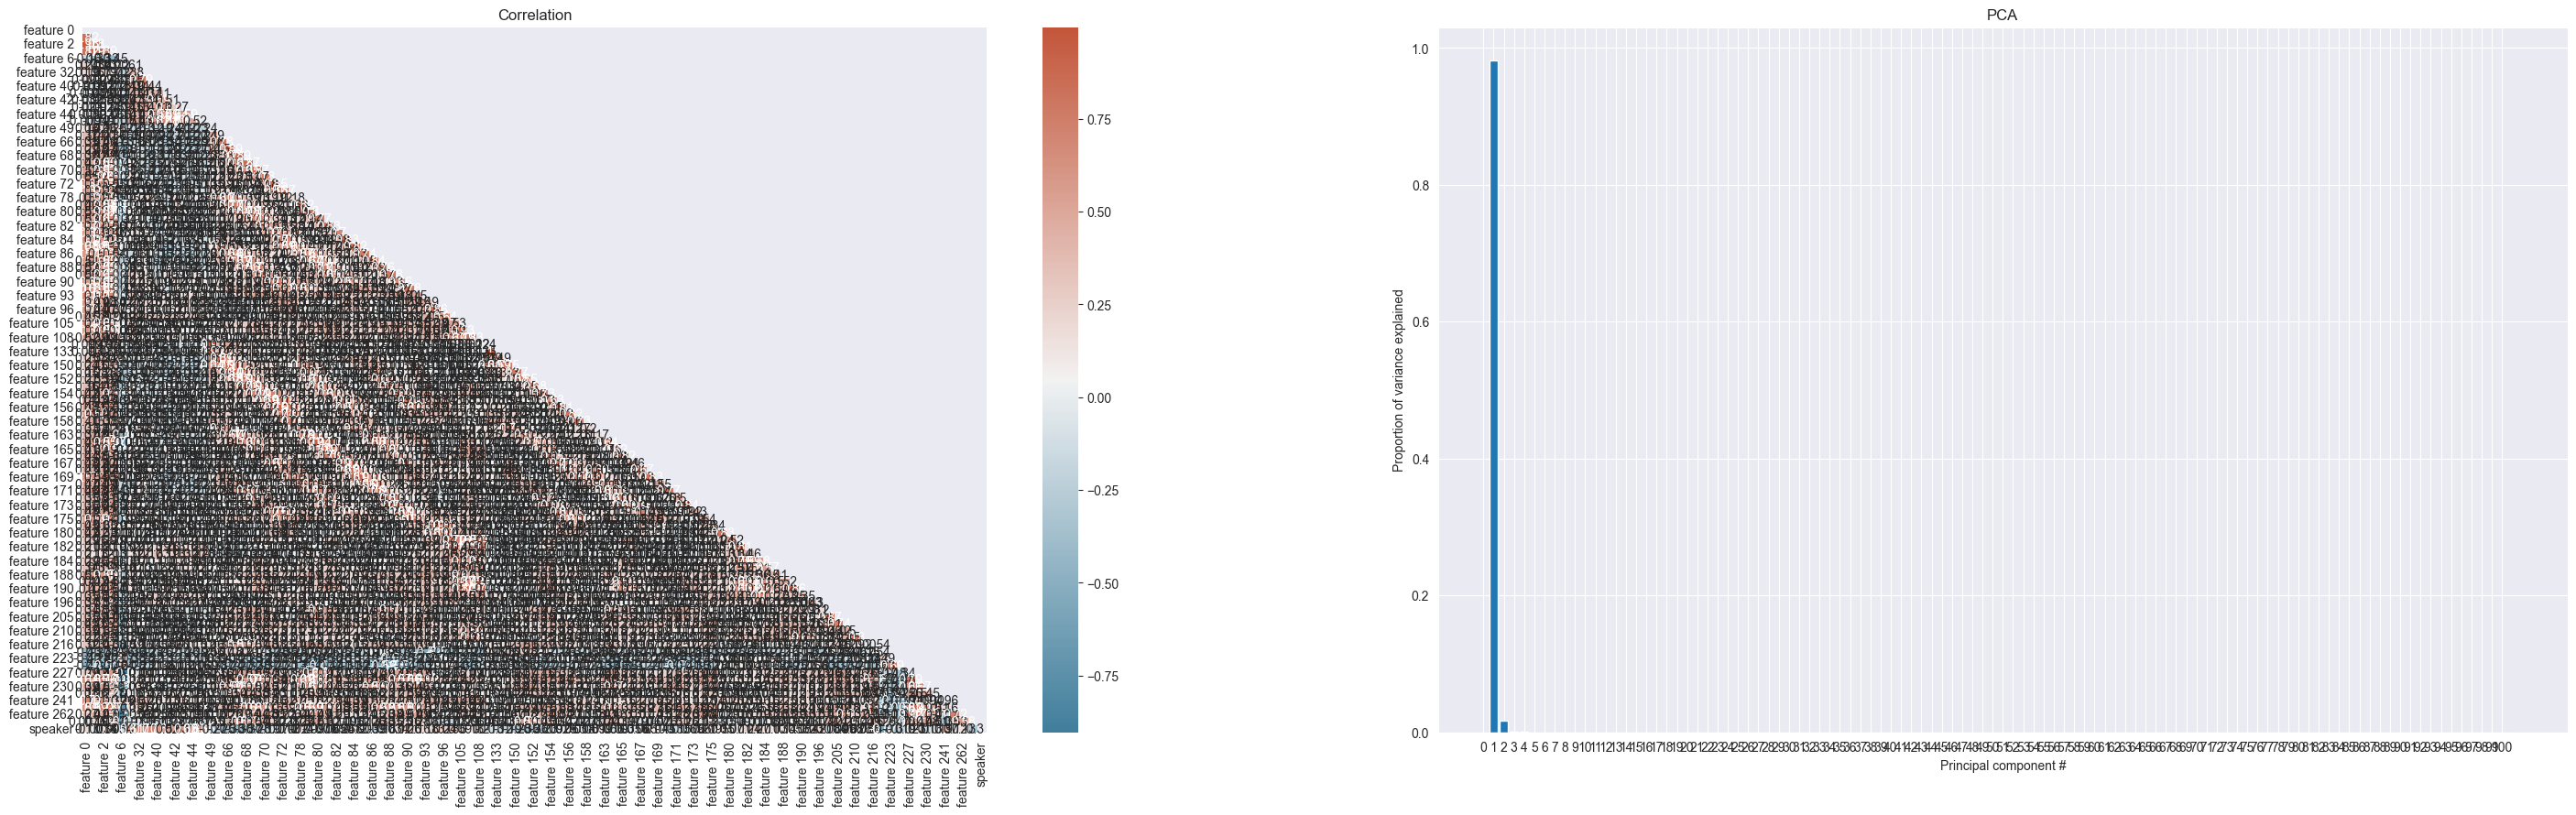

In [102]:
# stat_analysis(features_df.iloc[:,1:], 2)
stat_analysis(features_df[temp], 2)
temp.remove('speaker')

- We can deduce from the previous features that we are neglecting spectral centroid & spectral roll
- By calculating our final features again

In [106]:
# Functions we will use
def transform_audio(audio, FRAMESIZE, HOPLENGTH, MELS):

    # audio_noised, sr = librosa.load(audio, duration=2)
    # audio_array = noisereduce.reduce_noise(y=audio_noised, sr=sr)
    audio_array, sr = librosa.load(audio, duration=2)

    log_mel_audio_list_mean = []
    log_mel_audio_list_var = []
    mfccs_audio_list_mean = []
    mfccs_audio_list_var = []
    cqt_audio_list_mean = []
    cqt_audio_list_var = []
    chromagram_audio_list_mean = []
    chromagram_audio_list_var = []
    tone_audio_list_mean = []
    tone_audio_list_var = []

    log_mel_audio = librosa.power_to_db(librosa.feature.melspectrogram(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS))
    mfccs_audio = librosa.feature.mfcc(y=audio_array, n_mfcc=MELS, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)

    cqt_audio = np.abs(librosa.cqt(y=audio_array, sr=sr, hop_length=HOPLENGTH))
    chromagram_audio = librosa.feature.chroma_stft(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
    tone_audio = librosa.feature.tonnetz(y=audio_array, sr=sr)

    for i in range(len(log_mel_audio)):
         log_mel_audio_list_mean.append(log_mel_audio[i].mean())
         log_mel_audio_list_var.append(log_mel_audio[i].var())

    for i in range(len(mfccs_audio)):
         mfccs_audio_list_mean.append(mfccs_audio[i].mean())
         mfccs_audio_list_var.append(mfccs_audio[i].var())

    for i in range(len(cqt_audio)):
         cqt_audio_list_mean.append(cqt_audio[i].mean())
         cqt_audio_list_var.append(cqt_audio[i].var())

    for i in range(len(chromagram_audio)):
         chromagram_audio_list_mean.append(chromagram_audio[i].mean())
         chromagram_audio_list_var.append(chromagram_audio[i].var())

    for i in range(len(tone_audio)):
         tone_audio_list_mean.append(tone_audio[i].mean())
         tone_audio_list_var.append(tone_audio[i].var())

    sb_audio = librosa.feature.spectral_bandwidth(y=audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)

    ae_audio = fancy_amplitude_envelope(audio_array, FRAMESIZE, HOPLENGTH)
    rms_audio = librosa.feature.rms(audio_array, frame_length=FRAMESIZE, hop_length=HOPLENGTH)

    return np.hstack((mean(ae_audio), var(ae_audio), mean(rms_audio), var(rms_audio), mean(sb_audio), var(sb_audio), chromagram_audio_list_mean, chromagram_audio_list_var, tone_audio_list_mean, tone_audio_list_var, cqt_audio_list_mean, cqt_audio_list_var, mfccs_audio_list_mean, mfccs_audio_list_var, log_mel_audio_list_mean, log_mel_audio_list_var))


def fancy_amplitude_envelope(signal, framesize, hoplength):
    return np.array([max(signal[i:i+framesize]) for i in range(0, len(signal), hoplength)])

In [107]:
samples_no = len(fingerprints['data'])
features_length = len(transform_audio(fingerprints['data'].iloc[0], FRAMESIZE, HOPLENGTH, MELS))

In [109]:
features_df = pd.DataFrame()
features_df['data'] = fingerprints['data'].copy()
features_df['speaker'] = fingerprints['speaker'].copy()

for i in tqdm(range(features_length)):
    features_df[f'feature {i}'] = np.zeros(samples_no)

temp_array = []
for index, row in tqdm(features_df.iloc[:].iterrows()):
    if index < len(features_df)-1:
        array_1 = transform_audio(features_df.loc[index, ['data']][0], FRAMESIZE, HOPLENGTH, MELS)
        array_2 = transform_audio(features_df.loc[index+1, ['data']][0], FRAMESIZE, HOPLENGTH, MELS)
        combined_array = np.vstack((array_1, array_2))[0]
        temp_array.append(list(combined_array))

last_element = transform_audio(features_df.loc[len(features_df)-1, ['data']][0], FRAMESIZE, HOPLENGTH, MELS)
temp_array.append(list(last_element))


features_df.iloc[:,2:] = pd.DataFrame(temp_array).copy()
features_df

100%|██████████| 262/262 [00:00<00:00, 4517.66it/s]
192it [01:11,  2.69it/s]


,data,speaker,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,...,feature 252,feature 253,feature 254,feature 255,feature 256,feature 257,feature 258,feature 259,feature 260,feature 261
0,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.027843,0.002087,0.013634,0.000580,2409.485534,444727.497430,0.637220,0.566248,...,216.462494,176.181519,128.056839,149.693787,209.715164,148.801743,85.350876,59.285122,70.233040,65.921082
1,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.033648,0.004332,0.015390,0.000874,2302.179488,505915.237556,0.475199,0.436228,...,219.727203,170.745605,97.705536,127.613663,160.602402,135.815109,92.522125,74.727669,85.024757,104.147827
2,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.023385,0.001250,0.013316,0.000455,2280.717985,609810.794167,0.515015,0.428426,...,211.628494,204.353867,129.512207,116.327835,165.632950,190.573883,107.446518,43.292130,53.123344,51.931469
3,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.024663,0.000743,0.007930,0.000077,3207.467542,21074.717748,0.666652,0.625858,...,33.583759,28.132874,14.423258,5.036216,11.231256,8.625013,3.750520,0.598897,0.544173,0.362404
4,A:\Professional\Engineering CU\DSP_Data_New\op...,1,0.051932,0.020891,0.020185,0.001819,2241.470457,627994.777186,0.452060,0.515571,...,271.744171,223.154694,169.702164,114.854019,138.567413,167.287033,108.930367,58.179504,53.992485,42.848633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,A:\Professional\Engineering CU\DSP_Data_New\un...,4,0.015773,0.000217,0.005335,0.000030,3280.455819,22913.322885,0.569803,0.590974,...,39.137447,33.027950,7.295224,2.550004,4.270374,2.958375,1.051028,0.757277,0.480075,0.356831
188,A:\Professional\Engineering CU\DSP_Data_New\un...,2,0.047651,0.005682,0.018710,0.000937,2221.252490,696581.265398,0.534416,0.452144,...,260.199554,288.955322,152.535645,164.240067,200.829163,171.758636,178.650635,59.455601,42.259415,65.068863
189,A:\Professional\Engineering CU\DSP_Data_New\un...,2,0.051047,0.005127,0.019362,0.000863,2960.785129,289192.140017,0.536324,0.534323,...,154.288620,100.381271,21.474648,64.361992,51.115452,39.914986,15.535128,1.903714,2.089182,1.833574
190,A:\Professional\Engineering CU\DSP_Data_New\un...,2,0.039748,0.004213,0.015745,0.000659,2328.297810,688890.333144,0.527444,0.472268,...,273.135925,274.134705,121.783401,157.892990,211.429337,204.492920,150.704941,35.732243,24.178911,42.259094


In [110]:
features_df.iloc[:,2:].to_csv("..\\..\\data\\speaker_data.csv", index=False)
# features_df[temp].to_csv("..\\data\\speaker_data.csv", index=False)
features_df['speaker'].to_csv('..\\..\\data\\speaker_target.csv', index=False)